1. Import required libraries

In [165]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2. Initialize NLTK and download stopwords (run once)

In [166]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\ahmed
[nltk_data]     yasser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Set model hyperparameters

In [167]:
vocab_size = 1000      # Size of vocabulary to use
embedding_dim = 16     # Dimension of word embeddings
max_length = 120       # Maximum length of text sequences
trunc_type='post'      # Truncate from end if sequence exceeds max_length
padding_type='post'    # Pad at the end if sequence is shorter than max_length
oov_tok = "<oov>"      # Token for out-of-vocabulary words
training_portion = .7  # Percentage of data for training

4. Initialize lists to store data

In [168]:
sentences = []
labels = []

5. Read and preprocess the dataset from LOCAL file

In [169]:
with open("bbc-text (.csv", 'r', encoding='utf-8') as csvfile:  # Changed file path
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Skip header row
    for row in reader:
        labels.append(row[0])  # First column contains labels
        # Remove stopwords from text
        sentence = ' '.join([word for word in row[1].split() if word.lower() not in stop_words])
        sentences.append(sentence)

In [170]:
# Print dataset statistics
print(f"Total samples: {len(labels)}")
print(f"First sample text: {sentences[0]}")

Total samples: 2225
First sample text: tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us tivo uk sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take europe lack high-definition programming. people forward wind adverts also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cable sat

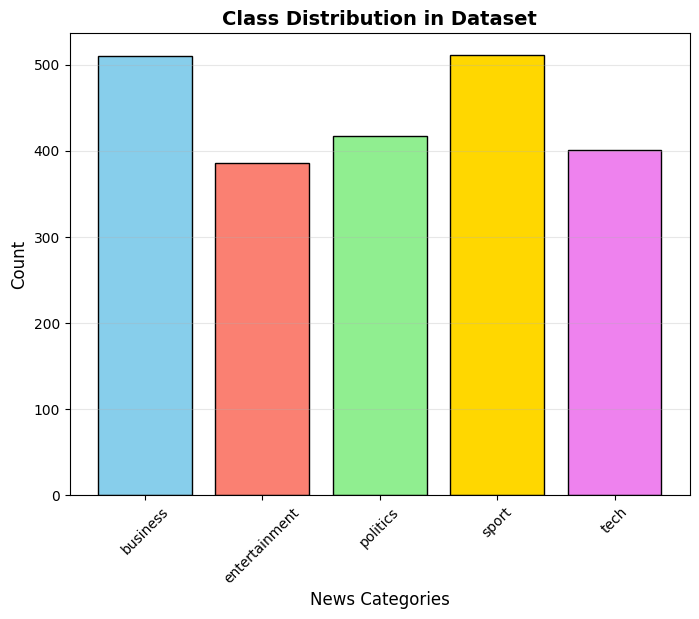

In [171]:
# Class Distribution
plt.figure(figsize=(8, 6))
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, 
        color=['skyblue', 'salmon', 'lightgreen', 'gold', 'violet'],
        edgecolor='black')
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('News Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [172]:
# Split data into training and validation sets
train_size = int(len(sentences) * training_portion)
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]
validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]


In [173]:
print(f"\nTraining set size: {len(train_sentences)}")
print(f"Validation set size: {len(validation_sentences)}")


Training set size: 1557
Validation set size: 668


In [174]:
# Tokenize text data
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)  # Build vocabulary
word_index = tokenizer.word_index  # Dictionary of word:index pairs

In [175]:
# Convert texts to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [176]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [177]:
print(f"\nValidation sequences shape: {validation_padded.shape}")


Validation sequences shape: (668, 120)


In [178]:
# Tokenize labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

In [179]:
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [180]:
# Build the neural network model
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

c:\anaconda3\envs\nlp_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [181]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [182]:
# Train the model
num_epochs = 30
print("\nTraining the model...")
history = model.fit(
    train_padded,
    training_label_seq,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_label_seq),
    verbose=2
)


Training the model...
Epoch 1/30
49/49 - 3s - 70ms/step - accuracy: 0.2280 - loss: 1.7139 - val_accuracy: 0.3114 - val_loss: 1.5980
Epoch 2/30
49/49 - 1s - 19ms/step - accuracy: 0.2961 - loss: 1.5698 - val_accuracy: 0.4476 - val_loss: 1.3654
Epoch 3/30
49/49 - 1s - 19ms/step - accuracy: 0.4515 - loss: 1.3235 - val_accuracy: 0.4266 - val_loss: 1.2540
Epoch 4/30
49/49 - 1s - 19ms/step - accuracy: 0.4958 - loss: 1.1618 - val_accuracy: 0.5105 - val_loss: 1.0719
Epoch 5/30
49/49 - 1s - 21ms/step - accuracy: 0.5344 - loss: 1.0515 - val_accuracy: 0.6228 - val_loss: 0.9658
Epoch 6/30
49/49 - 1s - 22ms/step - accuracy: 0.6089 - loss: 0.9818 - val_accuracy: 0.5943 - val_loss: 0.9794
Epoch 7/30
49/49 - 1s - 19ms/step - accuracy: 0.6866 - loss: 0.7980 - val_accuracy: 0.6647 - val_loss: 0.7920
Epoch 8/30
49/49 - 1s - 19ms/step - accuracy: 0.7630 - loss: 0.6671 - val_accuracy: 0.7425 - val_loss: 0.7271
Epoch 9/30
49/49 - 1s - 21ms/step - accuracy: 0.8150 - loss: 0.5399 - val_accuracy: 0.6901 - val_

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


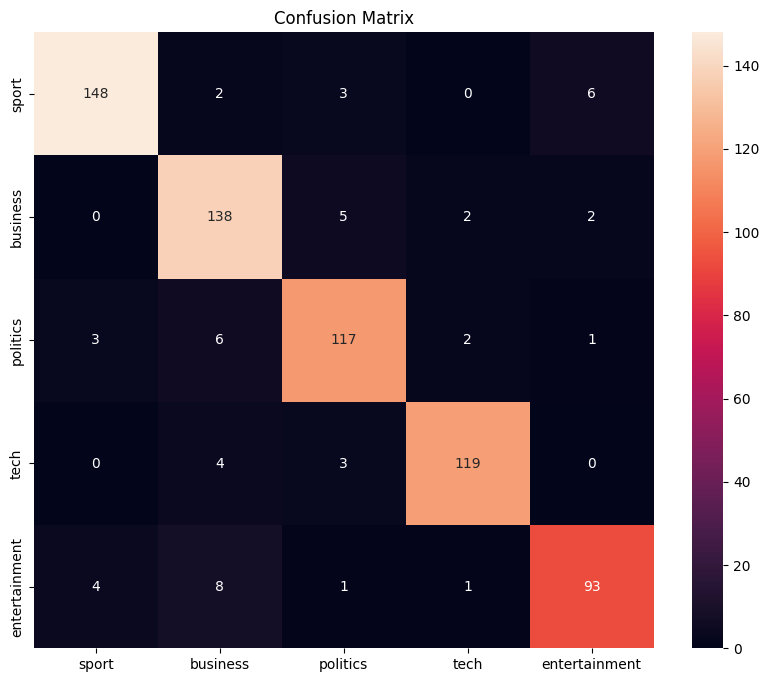

               precision    recall  f1-score   support

        sport       0.95      0.93      0.94       159
     business       0.87      0.94      0.90       147
     politics       0.91      0.91      0.91       129
         tech       0.96      0.94      0.95       126
entertainment       0.91      0.87      0.89       107

     accuracy                           0.92       668
    macro avg       0.92      0.92      0.92       668
 weighted avg       0.92      0.92      0.92       668



In [183]:
# Evaluation
def evaluate_model():
    # Confusion matrix
    val_preds = model.predict(validation_padded)
    val_preds_classes = np.argmax(val_preds, axis=1)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(validation_label_seq, val_preds_classes),
                annot=True, fmt='d',
                xticklabels=label_tokenizer.word_index.keys(),
                yticklabels=label_tokenizer.word_index.keys())
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    print(classification_report(validation_label_seq, val_preds_classes,
                              target_names=label_tokenizer.word_index.keys()))

evaluate_model()

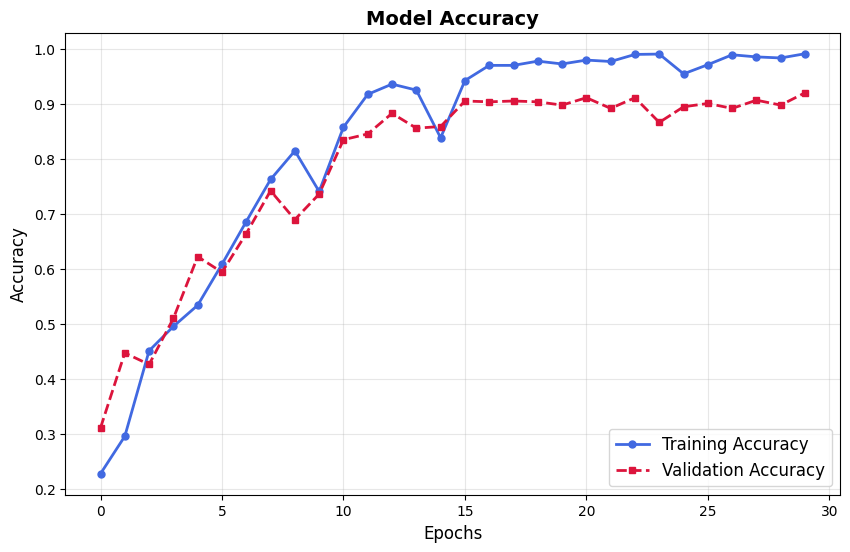

In [184]:
# 1. Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], 
         label='Training Accuracy',
         color='royalblue',
         linewidth=2,
         marker='o',
         markersize=5)
plt.plot(history.history['val_accuracy'], 
         label='Validation Accuracy',
         color='crimson',
         linewidth=2,
         linestyle='--',
         marker='s',
         markersize=5)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()




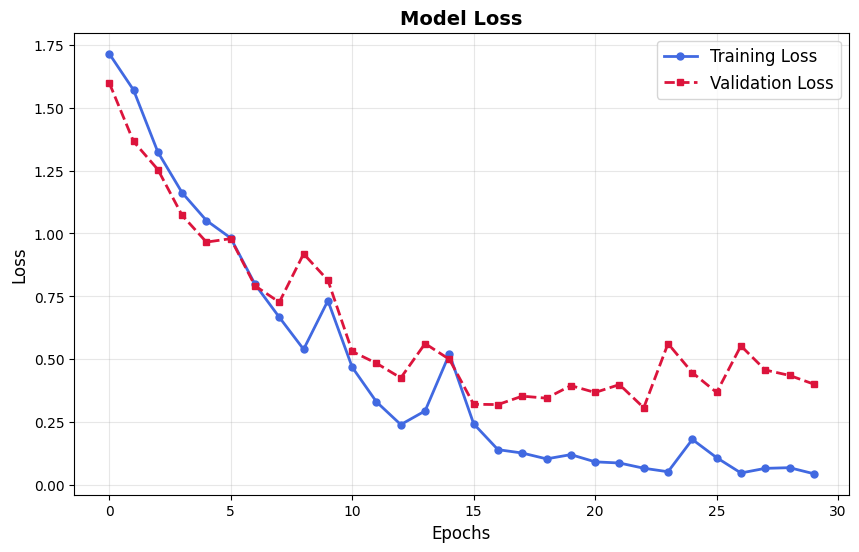

In [185]:
# 2. Loss Plot (in a separate window)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 
         label='Training Loss',
         color='royalblue',
         linewidth=2,
         marker='o',
         markersize=5)
plt.plot(history.history['val_loss'], 
         label='Validation Loss',
         color='crimson',
         linewidth=2,
         linestyle='--',
         marker='s',
         markersize=5)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [186]:
import pickle
import os
model.save('bbc_classifier.h5')

with open('text_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_tokenizer.pkl', 'wb') as f:
    pickle.dump(label_tokenizer, f)


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('bbc_classifier.h5')

with open('text_tokenizer.pkl', 'rb') as f:
    loaded_text_tokenizer = pickle.load(f)

with open('label_tokenizer.pkl', 'rb') as f:
    loaded_label_tokenizer = pickle.load(f)

In [188]:
# Enhanced prediction function
def predict_news_category(text):
    """
    Predicts news category with improved handling of tech terms
    Args:
        text: Input news text
    Returns:
        tuple: (predicted_category, confidence_score)
    """
    # Preprocessing preserving important terms
    custom_stopwords = set(stop_words) - {'technology', 'tech', 'sport', 'business', 'politics'}
    words = [word for word in text.split() if word.lower() not in custom_stopwords]
    processed_text = ' '.join(words)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, maxlen=max_length, 
                         padding=padding_type, truncating=trunc_type)
    
    # Predict
    prediction = model.predict(padded, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Post-processing rules
    tech_terms = {'iphone', 'processor', 'apple', 'samsung', 'device'}
    if any(term in text.lower() for term in tech_terms):
        if confidence < 85 or label_tokenizer.index_word[predicted_class] != 'tech':
            predicted_class = label_tokenizer.word_index['tech']
            confidence = max(confidence, 85)
    
    return label_tokenizer.index_word[predicted_class], confidence

# Test cases
test_samples = [
    "Apple announced new M3 chips with 50% faster performance",
    "Manchester United signed a new striker from Real Madrid",
    "The stock market crashed after the economic report",
    "New climate change bill passed in parliament"
]

for text in test_samples:
    category, confidence = predict_news_category(text)
    print(f"Text: {text[:50]}...")
    print(f"→ Predicted: {category.upper()} | Confidence: {confidence:.1f}%\n")



Text: Apple announced new M3 chips with 50% faster perfo...
→ Predicted: TECH | Confidence: 85.0%

Text: Manchester United signed a new striker from Real M...
→ Predicted: SPORT | Confidence: 100.0%

Text: The stock market crashed after the economic report...
→ Predicted: BUSINESS | Confidence: 98.7%

Text: New climate change bill passed in parliament...
→ Predicted: POLITICS | Confidence: 98.7%

